In [1]:
# === LSTM-DQN for Forex Forecasting ===
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os



In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")



✅ Using device: cuda


In [3]:
# === Parameters ===
symbols = ['USDJPY=X', 'EURUSD=X', 'GBPUSD=X']
clean_names = ['USDJPY', 'EURUSD', 'GBPUSD']
features = [
    'Close', 'MA10', 'MA50', 'EMA10', 'EMA50', 'STD20',
    'Bollinger_Width', 'RSI', 'MOM', 'MACD', 'ATR'
]
sequence_length = 60
prediction_length = 1
state_size = len(features)

# === Feature Engineering ===
def compute_features(data):
    data['MA10'] = data['Close'].rolling(10).mean()
    data['MA50'] = data['Close'].rolling(50).mean()
    data['EMA10'] = data['Close'].ewm(span=10).mean()
    data['EMA50'] = data['Close'].ewm(span=50).mean()
    data['STD20'] = data['Close'].rolling(20).std()
    data['Bollinger_High'] = data['MA10'] + 2 * data['STD20']
    data['Bollinger_Low'] = data['MA10'] - 2 * data['STD20']
    data['Bollinger_Width'] = data['Bollinger_High'] - data['Bollinger_Low']
    pct_change = data['Close'].pct_change()
    data['RSI'] = 100 - (100 / (1 + pct_change.rolling(14).mean() / pct_change.rolling(14).std()))
    data['MOM'] = data['Close'].diff(10)
    data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = tr.rolling(14).mean()
    return data[features].dropna()

fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
min_len = min(len(df) for df in fx_data.values())
aligned = [fx_data[s][-min_len:].to_numpy() for s in symbols]
fx_combined = np.stack(aligned, axis=1).transpose(1, 0, 2)
df_dict = {name: pd.DataFrame(fx_combined[i], columns=features) for i, name in enumerate(clean_names)}
print("✅ Data loaded and processed.")



/tmp/ipykernel_9990/631695192.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_9990/631695192.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_9990/631695192.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
[*********************100%***********************]  1 of 1 completed

✅ Data loaded and processed.



🚀 Training USDJPY
Epoch 0 - Loss: 0.03564, Accuracy: 0.1508
Epoch 5 - Loss: 0.00304, Accuracy: 0.4507
Epoch 10 - Loss: 0.00233, Accuracy: 0.4904
Epoch 15 - Loss: 0.00194, Accuracy: 0.5084
Epoch 20 - Loss: 0.00172, Accuracy: 0.5405
Epoch 25 - Loss: 0.00162, Accuracy: 0.5241
Epoch 30 - Loss: 0.00143, Accuracy: 0.5838
Epoch 35 - Loss: 0.00148, Accuracy: 0.5501
Epoch 40 - Loss: 0.00165, Accuracy: 0.4575
Epoch 45 - Loss: 0.00133, Accuracy: 0.5822


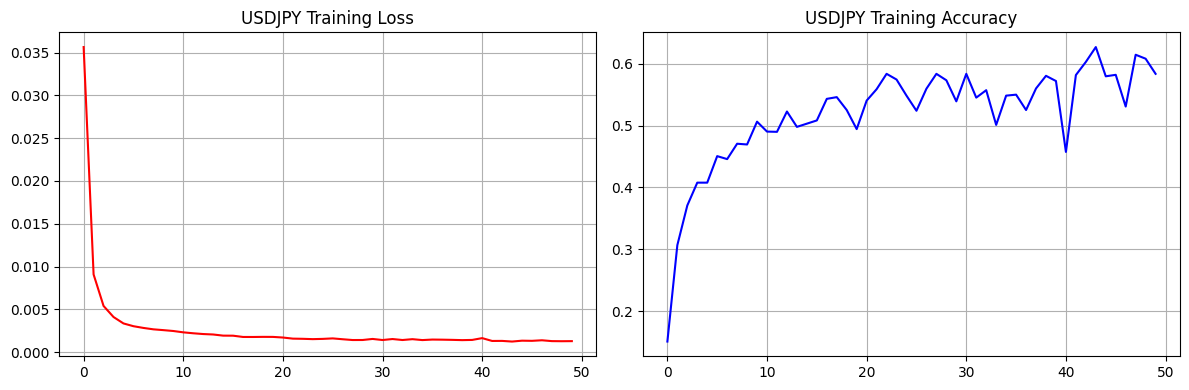

Saved USDJPY model to saved_models/USDJPY_lstm_dqn.pth

🚀 Training EURUSD
Epoch 0 - Loss: 0.03510, Accuracy: 0.1423
Epoch 5 - Loss: 0.00280, Accuracy: 0.3617
Epoch 10 - Loss: 0.00191, Accuracy: 0.3921
Epoch 15 - Loss: 0.00156, Accuracy: 0.4455
Epoch 20 - Loss: 0.00138, Accuracy: 0.4511
Epoch 25 - Loss: 0.00126, Accuracy: 0.4707
Epoch 30 - Loss: 0.00135, Accuracy: 0.4547
Epoch 35 - Loss: 0.00118, Accuracy: 0.4988
Epoch 40 - Loss: 0.00113, Accuracy: 0.5012
Epoch 45 - Loss: 0.00106, Accuracy: 0.5168


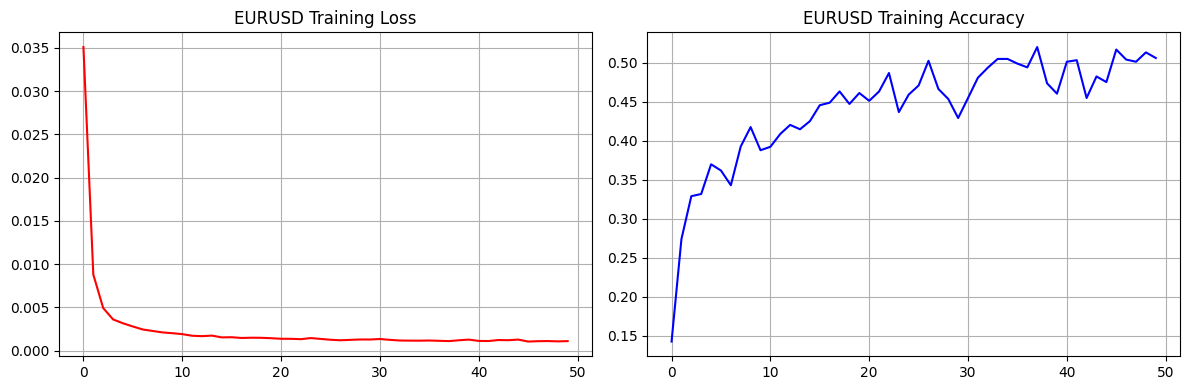

Saved EURUSD model to saved_models/EURUSD_lstm_dqn.pth

🚀 Training GBPUSD
Epoch 0 - Loss: 0.03213, Accuracy: 0.1347
Epoch 5 - Loss: 0.00232, Accuracy: 0.3905
Epoch 10 - Loss: 0.00176, Accuracy: 0.4383
Epoch 15 - Loss: 0.00130, Accuracy: 0.4908
Epoch 20 - Loss: 0.00125, Accuracy: 0.4912
Epoch 25 - Loss: 0.00105, Accuracy: 0.5229
Epoch 30 - Loss: 0.00097, Accuracy: 0.5505
Epoch 35 - Loss: 0.00094, Accuracy: 0.5650
Epoch 40 - Loss: 0.00088, Accuracy: 0.5794
Epoch 45 - Loss: 0.00088, Accuracy: 0.5914


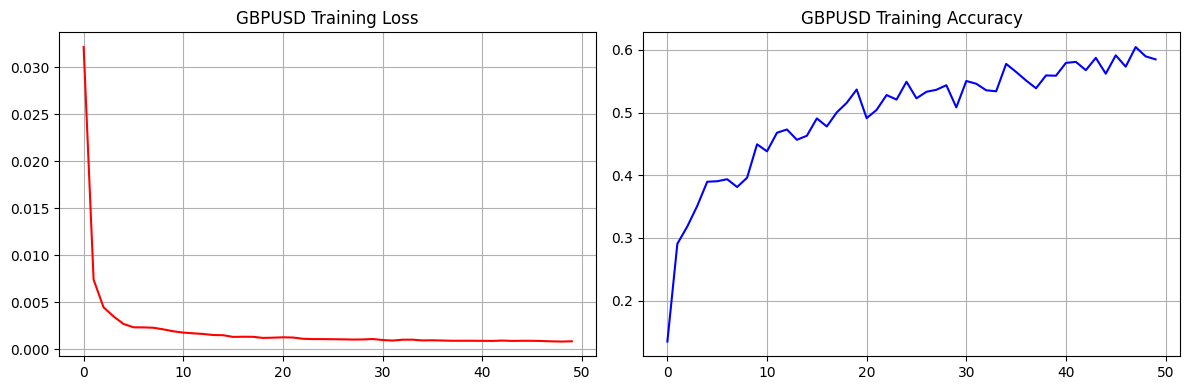

Saved GBPUSD model to saved_models/GBPUSD_lstm_dqn.pth
✅ All models trained, saved, and evaluated.


In [4]:
# Updated LSTM-DQN Model with tuned layers and dropout
class CustomModel(nn.Module):
    def __init__(self, state_size, prediction_length):
        super().__init__()
        self.lstm1 = nn.LSTM(state_size, 512, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(512, 512, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(512, 1024)
        self.relu1 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, prediction_length * state_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x.view(x.size(0), prediction_length, state_size)

# Train and Predict
currency_models = {}
currency_scalers = {}
currency_predictions = {}

os.makedirs("saved_models", exist_ok=True)

for pair in clean_names:
    print(f"\n\U0001F680 Training {pair}")
    df = df_dict[pair].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X = np.array([scaled[i:i+sequence_length] for i in range(len(scaled) - sequence_length - prediction_length)])
    y = np.array([scaled[i+sequence_length:i+sequence_length+prediction_length] for i in range(len(scaled) - sequence_length - prediction_length)])

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = CustomModel(state_size=state_size, prediction_length=prediction_length).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    losses, accuracies = [], []
    for epoch in range(50):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred_close = pred[:, :, 0].mean(dim=1)
            true_close = yb[:, :, 0].mean(dim=1)
            correct += (torch.abs(pred_close - true_close) < 0.02).sum().item()
            total += len(true_close)

        acc = correct / total
        losses.append(total_loss / len(dataloader))
        accuracies.append(acc)

        if epoch % 5 == 0:
            print(f"Epoch {epoch} - Loss: {losses[-1]:.5f}, Accuracy: {acc:.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss', color='red')
    plt.title(f'{pair} Training Loss')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy (\u00b12%)', color='blue')
    plt.title(f'{pair} Training Accuracy')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Save trained model
    model_path = f"saved_models/{pair}_lstm_dqn.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved {pair} model to {model_path}")


    # Evaluate predictions
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor.to(device)).cpu().numpy()
        actual = scaler.inverse_transform(y_tensor[:, -1, :])
        predicted = scaler.inverse_transform(preds[:, -1, :])

    currency_models[pair] = model
    currency_scalers[pair] = scaler
    currency_predictions[pair] = (actual[:, 0], predicted[:, 0])

print("\u2705 All models trained, saved, and evaluated.")


📊 Evaluation Metrics
USDJPY: RMSE = 0.9842, MAE = 0.7447


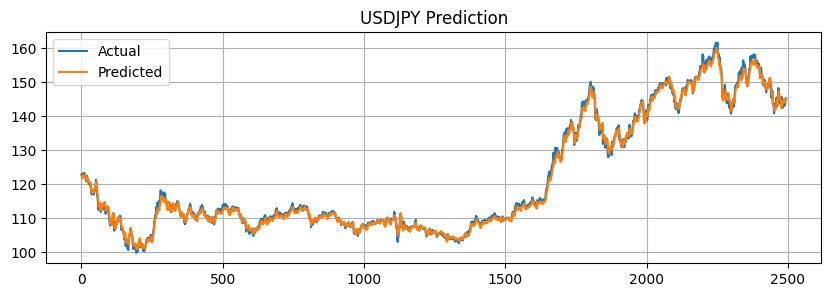

EURUSD: RMSE = 0.0069, MAE = 0.0054


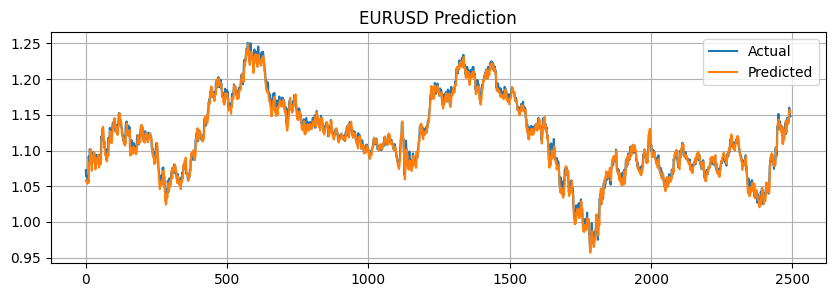

GBPUSD: RMSE = 0.0084, MAE = 0.0063


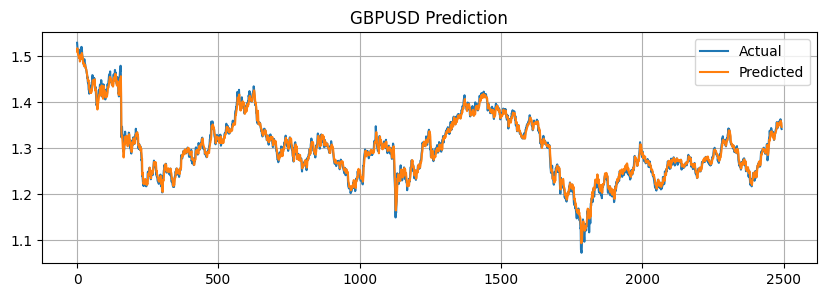

In [5]:
# === Evaluation ===
print("\n📊 Evaluation Metrics")
for pair in clean_names:
    actual, predicted = currency_predictions[pair]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"{pair}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    plt.figure(figsize=(10, 3))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f"{pair} Prediction")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
# === Simple Trading Simulation ===
def trading_decision(prev_price, predicted_price, threshold=0.002):
    change = (predicted_price - prev_price) / prev_price
    if change > threshold:
        return "LONG"
    elif change < -threshold:
        return "SHORT"
    return "HOLD"

initial_capital = 1000.0
margin_per_trade = 10.0
leverage = 5
liq_threshold = 0.3

capital = {k: initial_capital for k in clean_names}
position = {k: 0 for k in clean_names}
entry_price = {k: 0 for k in clean_names}

print("\n=== 🔁 Backtest Simulation ===")
start_day = len(df_dict[clean_names[0]]) - 120
end_day = len(df_dict[clean_names[0]]) - 30

for t in range(start_day, end_day):
    print(f"\n📅 Day {t - start_day + 1}")
    for pair in clean_names:
        df = df_dict[pair]
        model = currency_models[pair]
        scaler = currency_scalers[pair]

        if t < sequence_length:
            continue

        window_data = df.iloc[t - sequence_length:t].values
        scaled_input = scaler.transform(window_data)
        input_tensor = torch.tensor(scaled_input.reshape(1, sequence_length, -1), dtype=torch.float32).to(device)

        model.eval()
        with torch.no_grad():
            pred_scaled = model(input_tensor).cpu().numpy()
            padded = np.zeros((1, state_size))
            padded[0, 0] = pred_scaled[0, 0, 0]
            pred_price = scaler.inverse_transform(padded)[0, 0]

        actual_price = df.iloc[t]['Close']
        action = trading_decision(actual_price, pred_price)

        if position[pair] == 0:
            if action == "LONG":
                position[pair] = 10
                entry_price[pair] = actual_price
                print(f"🟢 {pair}: ENTER LONG at {actual_price:.4f}")
            elif action == "SHORT":
                position[pair] = -10
                entry_price[pair] = actual_price
                print(f"🔴 {pair}: ENTER SHORT at {actual_price:.4f}")
        else:
            pnl = position[pair] * (actual_price - entry_price[pair]) * leverage * margin_per_trade / actual_price
            equity = capital[pair] + pnl
            if equity / (margin_per_trade * abs(position[pair])) < liq_threshold:
                print(f"⚠️ {pair}: Liquidation at {actual_price:.4f} | PnL = {pnl:.2f}")
                capital[pair] = equity
                position[pair] = 0
                entry_price[pair] = 0
            elif abs(pnl) > 50:
                print(f"💰 {pair}: Exit trade at {actual_price:.4f} | PnL = {pnl:.2f}")
                capital[pair] += pnl
                position[pair] = 0
                entry_price[pair] = 0

        print(f"{pair} ➤ Action: {action} | Capital: ${capital[pair]:.2f} | Position: {position[pair]}")



=== 🔁 Backtest Simulation ===

📅 Day 1
🔴 USDJPY: ENTER SHORT at 157.7190
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
🟢 EURUSD: ENTER LONG at 1.0352
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
🟢 GBPUSD: ENTER LONG at 1.2519
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 2
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 3
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 4
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 5
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: H

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 10
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 11
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 12
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 13
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 14
USDJPY ➤ Action: HOLD | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | C

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 19
USDJPY ➤ Action: HOLD | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 20
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 21
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 22
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 23
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Cap

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 28
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 29
USDJPY ➤ Action: HOLD | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 30
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 31
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 32
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT |

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 37
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 38
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 39
USDJPY ➤ Action: HOLD | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 40
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 41
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 46
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 47
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 48
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 49
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 50
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | 

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 55
USDJPY ➤ Action: HOLD | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 56
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 57
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 58
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 59
USDJPY ➤ Action: SHORT | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capita

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 64
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 65
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 66
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 67
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 68
USDJPY ➤ Action: LONG | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: LONG | Cap

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 73
USDJPY ➤ Action: HOLD | Capital: $1000.00 | Position: -10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 74
💰 USDJPY: Exit trade at 143.2210 | PnL = 50.61
USDJPY ➤ Action: LONG | Capital: $1050.61 | Position: 0
EURUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 75
USDJPY ➤ Action: HOLD | Capital: $1050.61 | Position: 0
EURUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 76
🟢 USDJPY: ENTER LONG at 141.9280
USDJPY ➤ Action: LONG | Capital: $1050.61 | Position: 10
EURUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 77
USDJPY ➤ Action: LONG | Capital: $1050.61 | Position: 10
💰 EURUSD

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: HOLD | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10

📅 Day 82
USDJPY ➤ Action: LONG | Capital: $1050.61 | Position: 10
EURUSD ➤ Action: SHORT | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 83
USDJPY ➤ Action: LONG | Capital: $1050.61 | Position: 10
EURUSD ➤ Action: SHORT | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: SHORT | Capital: $1000.00 | Position: 10

📅 Day 84
USDJPY ➤ Action: SHORT | Capital: $1050.61 | Position: 10
EURUSD ➤ Action: SHORT | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 85
USDJPY ➤ Action: SHORT | Capital: $1050.61 | Position: 10
EURUSD ➤ Action: HOLD | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: HOLD | Capital: $1000.00 | Position: 10

📅 Day 86
USDJPY ➤ Action: HOLD | Capital: $1050.61 | Position: 10
EURUSD ➤ Action: SHORT | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: HOLD | Capita

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD ➤ Action: LONG | Capital: $1050.42 | Position: 10
GBPUSD ➤ Action: LONG | Capital: $1000.00 | Position: 10


/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
# === ROI Report ===
print("\n📊 === Final ROI Report ===")
total_initial = len(clean_names) * initial_capital
total_final = sum(capital.values())

for pair in clean_names:
    pnl = capital[pair] - initial_capital
    print(f"{pair}: Final = ${capital[pair]:.2f} | PnL = ${pnl:.2f}")

roi = (total_final / total_initial - 1) * 100
print(f"\nTotal ROI: {roi:.2f}%")
print("✅ Simulation Complete.")


📊 === Final ROI Report ===
USDJPY: Final = $1050.61 | PnL = $50.61
EURUSD: Final = $1050.42 | PnL = $50.42
GBPUSD: Final = $1000.00 | PnL = $0.00

Total ROI: 3.37%
✅ Simulation Complete.
